# xemc3

## Readable EMC3 data analysis in python

David Schwörer

based on work from Tom Nicholas, John Omotani & Rhys Doyle for xBOUT

(dave@ipp.mpg.de)

# Outline

- Multidimensional data analysis
- What is xarray?
- numpy vs xarray - syntax comparison 
- xarray basic features
- xemc3

# Multidimensional data analysis

Most plasma physicists have some similar data analysis requirements:

- Relatively large datasets (up to 100's GBs)
- Multidimensional
- Warped-grid
- Several plasma quantities (density, temperature, ...)
- Lots of metadata to attach (simulation input file, shot number ...)
- Visualise multiple dimensions easily
- Apply mathematical operations over many dimensions easily and clearly

# What is xarray?

xarray is an open-source python library which aims to provide Pandas-like labelling, visualisation & analysis functionality for N-dimensional data.

Developed by atmospheric physicists, who have similar data analysis needs to us.

They also have relatively large, multidimensional, warped-grid, fluid turbulence datasets to visualise and analyse.

Sponsored by NumFocus, who also support NumPy, MatPlotLib, Pandas, Jupyter, IPython, Julia...

Large open-source project: github says used by 1.5k other packages

### xarray basic features: 
- Labelled multidimensional data
- Clear syntax for operations
- Lazy loading into memory
- Plotting convenience

# xarray: Labelled multidimensional data

xarray wraps numpy arrays with their `dims` as `DataArray`s.

Can also select data via special variables called `coords`.

Coordinates can be multidimensional
(e.g. for mapping Orthogonal toroidal coordinates -> field-aligned coordinates)

Multiple `DataArrays` are stored in same `Dataset`.

For example, imagine we had some output from an atmospheric fluid simulation...

<img src="dataset-diagram.png">

In [ ]:
<xarray.Dataset>
Dimensions:        (t: 8, x: 8, y: 8)
Coordinates:
  * t              (t) int64 0 1 2 3 4 5 6 7 8
  * x              (x) int64 0 1 2 3 4 5 6 7 8
  * y              (y) int64 0 1 2 3 4 5 6 7 8
    latitude       (x, y) float32 numpy.array(8, 8)
    longitude      (x, y) float32 numpy.array(8, 8)
Data variables:
    temperature    (t, x, y) float32 numpy.array(8, 8, 8)
    precipitation  (t, x, y) float32 numpy.array(8, 8, 8)
    
Attributes:
    reference_time 123.0

Also carries around a dictionary of "attributes". Could be used to store input files (`fort.1`, `fort.2`, `fort.3`) for simulations.

# numpy vs xarray: Clearer syntax for typical operations

Problem: We have some data $ne(t,x,y,z)$, and we want to find the maximum over time of the spatially-averaged density at the separatrix. 

i.e. find $\text{max}(<n(t,x=\text{separatrix})>)$, where $<...>$ is an average over $y$ and $z$: 

In [ ]:
# bare numpy
max_separatrix_density = np.max(np.mean(ne[:, sep_x, ...], axis=(2,3)), axis=0)
# xarray
max_separatrix_density = ds['ne'].isel(x=sep_x).mean(dim=('y', 'z')).max(dim='t')

The xarray code is **clearer**, more **general**, contains **less magic** numbers, and the order of operations applied reads **left-to-right**.

# Copycats in other languages

Similar libraries implemented in at least 2 other languages, who credit inspiration to `xarray`.

C++ - [xframe](https://github.com/QuantStack/xframe)

Julia - [AxisArrays.jl](https://github.com/JuliaArrays/AxisArrays.jl)

# xarray: Lazy loading into memory

xarray uses the netCDF format in the backend.

Lazily loads data values - avoids wasting RAM on unneeded values.

In [ ]:
import xarray as xr

# Open a 100GB file
ds = xr.open_dataset('simulation_data.nc')

# Select a 1GB subset of the data
data = ds.isel(y=0)

# Data is only loaded into memory here, when we actually need it
result = some_maths(data)

# xarray: Plotting convenience

xarray provides plotting functions which wrap matplotlib.

In [ ]:
data_slice = ds['phi'].isel(y=34, t=-1)

data_slice.plot()

<img src="phi_2D_y=34.png" alt="Drawing" style="width: 600px;">

These plotting functions automatically use an appropriate type of plot for the dimension of the data (1D, 2D) and set labels automatically based on meta data

In [ ]:
data = ds['T'].mean(dim=('t', 'y', 'z'))

fig, ax = plt.subplots()
data.plot.line(ax=ax)

plot_separatrix(data, sep_position, ax=ax)

<img src="T_profile.png" alt="Drawing" style="width: 600px;">

# xarray + dask: Memory chunking

If you also install the dask library (literally that's it, no other compiling or anything required), xarray will provide the option to load data into memory in chunks.

In [ ]:
ds = xr.open_dataset('example-data.nc', chunks={'time': 10})

print(ds)

In [ ]:
<xarray.Dataset>
Dimensions:      (latitude: 180, longitude: 360, time: 365)
Coordinates:
  * time         (time) datetime64[ns] 2015-01-01 2015-01-02 2015-01-03 ...
  * longitude    (longitude) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 ...
  * latitude     (latitude) float64 89.5 88.5 87.5 86.5 85.5 84.5 83.5 82.5 ...
Data variables:
    temperature  (time, latitude, longitude) float64 dask.array<shape=(365, 180, 360), chunksize=(10, 180, 360)>

Now if you apply any xarray or any "embarrassingly parallel" numpy function to this dataset then it will compute the result only on one chunk at a time, and combine the results at the end.

This is very useful when you have "medium data": data larger than your system's RAM but not "big data". 

# xarray + dask: Parallel analysis

dask can also automatically parallelize the operation of any xarray function, and most numpy and scipy functions, using the ``apply_ufunc`` helper function: 

In [ ]:
result = xr.apply_ufunc(some_numpy_analysis_fn, ds, dask='parallelized', output=[float])

Chunking and parallelization through dask integration should allow you to easily scale up whatever analysis you were doing with numpy to work on datasets that are 100's of GBs in size.

In [4]:
import xarray as xr

squared_error = lambda x, y: (x - y) ** 2

arr1 = xr.DataArray([0, 1, 2, 3], dims='x')

xr.apply_ufunc(squared_error, arr1, 1)

<xarray.DataArray (x: 4)>
array([1, 0, 1, 4])
Dimensions without coordinates: x

In [7]:
import numpy as np

def vector_norm(x, dim, ord=None):
    return xr.apply_ufunc(np.linalg.norm, x,
                          input_core_dims=[[dim]],
                          kwargs={'ord': ord, 'axis': -1})

In [8]:
vector_norm(arr1, dim='x')

<xarray.DataArray ()>
array(3.741657)

# xemc3

### Loading data

xemc3 allows you to load your EMC3-EIRENE output into an xarray dataset.

Need to parse various text files to get the data

In [ ]:
import xemc3

ds = xemc3.load.all("./mysimulation/")

print(ds)

In [ ]:
Read in:
<xarray.Dataset>
Dimensions:                       (delta_phi: 2, delta_r: 2, delta_theta: 2, phi: 36, r: 139, theta: 512)
Coordinates:
    R_bounds                      (r, theta, phi, delta_r, delta_theta, delta_phi) float64 ...
    z_bounds                      (r, theta, phi, delta_r, delta_theta, delta_phi) float64 ...
    phi_bounds                    (phi, delta_phi) float64 0.0 ... 0.6283
Dimensions without coordinates: delta_phi, delta_r, delta_theta, phi, r, theta
Data variables: (12/34)
    _plasma_map                   (r, theta, phi) int64 379649 379649 ... 398090
    ne                            (r, theta, phi) float64 nan nan ... nan nan
    nZ1                           (r, theta, phi) float64 nan nan ... nan nan
    nZ2                           (r, theta, phi) float64 nan nan ... nan nan
    nZ3                           (r, theta, phi) float64 nan nan ... nan nan
    nZ4                           (r, theta, phi) float64 nan nan ... nan nan
    ...                            ...
    IMPURITY_IONIZATION_SOURCE_0  (r, theta, phi) float64 nan nan ... nan nan
    IMPURITY_IONIZATION_SOURCE_1  (r, theta, phi) float64 nan nan ... nan nan
    IMPURITY_NEUTRAL_0            (r, theta, phi) float64 nan nan ... nan nan
    IMP_RADIATION_0               (r, theta, phi) float64 nan nan ... nan nan
    FLUX_CONSERVATION_0           (r, theta, phi) float64 nan nan ... nan nan
    LG_CELL_0                     (r, theta, phi) float64 nan nan ... nan nan

### Storing data as netcdf


Initial loading is slow, as all files need to be parsed.

Storing as netcdf allows having all data in a single file.

Much faster to read netcdf than text files.

Additionally benefit from lazy loading.

In [ ]:
import xemc3

ds = xemc3.load.all("./mysimulation/")
ds.to_netcdf('mysimulation.nc')

```bash
$ xemc3-to-netcdf mysimulation
```

## EMC3 uses volume data

Volume based data (rather than point data) is not well supported by xarray.

Additional `delta_*` dimension allows retaining support for slicing etc

xemc3 provides method to get `n+1` version:

In [1]:
import xarray as xr
import xemc3

ds = xr.open_dataset("simulation.nc")

ds.emc3["phi_corners"]

<xarray.DataArray (phi: 37)>
array([0.        , 0.01745329, 0.03490659, 0.05235988, 0.06981317,
       0.08726646, 0.10471976, 0.12217305, 0.13962634, 0.15707963,
       0.17453293, 0.19198622, 0.20943951, 0.2268928 , 0.2443461 ,
       0.26179939, 0.27925268, 0.29670597, 0.31415927, 0.33161256,
       0.34906585, 0.36651914, 0.38397244, 0.40142573, 0.41887902,
       0.43633231, 0.45378561, 0.4712389 , 0.48869219, 0.50614548,
       0.52359878, 0.54105207, 0.55850536, 0.57595865, 0.59341195,
       0.61086524, 0.62831853])
Dimensions without coordinates: phi

## Accessors for EMC3 specific functionality

"accessors" provided for attaching your own methods to xarray objects

In [ ]:
# Allows for attaching methods without subclassing xarray objects (which would be complex)
ds.emc3.do_something_emc3_specific()

# Also clearly separates the namespaces

## Plotting with real geometries

(139, 512)


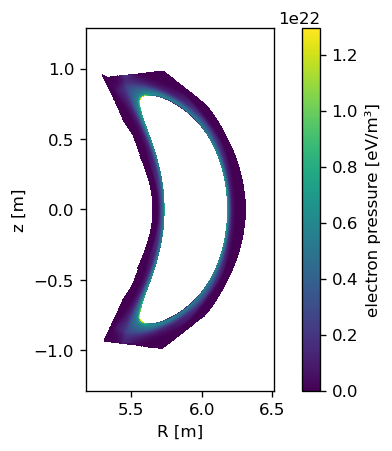

In [4]:
import matplotlib.pyplot as plt
ds["Pe"] = ds.ne * ds.Te
ds.Pe.attrs = dict(long_name = "electron pressure", units="eV/m³")
ds.emc3.plot_Rz('Pe',phi=0, figure=plt.figure(dpi=120))

## Evaluate at abitrary position

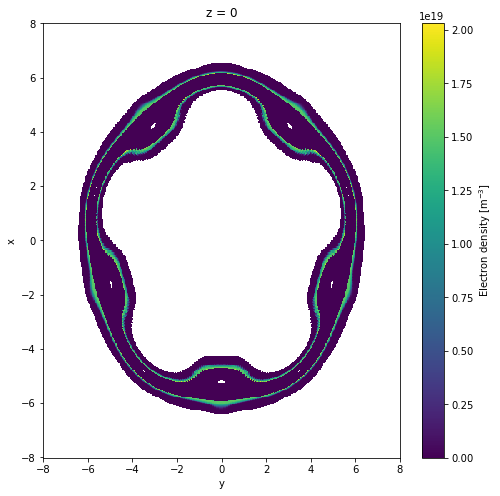

In [2]:
import numpy as np
nx = ny = 500
pos = xr.Dataset(coords=dict(x=np.linspace(-8, 8, nx), y=np.linspace(-8, 8, ny), z=0))
mapped = ds.emc3.evaluate_at_xyz(
    pos.x, pos.y, 0, "ne", periodicity=5, updownsym=True, delta_phi=np.pi / 180
)
mapped.ne.plot(figsize=(8,8), aspect=1)

## Averaging simulations

Averaging over several iteration can reduce noise


```bash
$ xemc3-append-time samefolder```

Continue simulation

(repeat several times)

[Documentation](https://xemc3.readthedocs.io/en/next/cli.html#xemc3-append-time---cli-interface)

In [ ]:
import os
import xarray as xr
import xemc3
ds = xr.open_dataset("samefolder.nc")
os.mkdir("averaged/")
xemc3.write.fortran.all(ds.emc3.mean_time(), "averaged/")

## Analysing target fluxes

Read data from `POST_PROCESSING` power deposition

In [2]:
import xemc3
tar = xemc3.load.plates("./power-deposition/")
tar

<xarray.Dataset>
Dimensions:     (delta_phi: 2, delta_x: 2, phi: 560, plate_ind: 22, x: 100)
Coordinates:
    R_bounds    (plate_ind, phi, x, delta_phi, delta_x) float64 ...
    z_bounds    (plate_ind, phi, x, delta_phi, delta_x) float64 ...
    phi_bounds  (plate_ind, phi, x, delta_phi, delta_x) float64 ...
Dimensions without coordinates: delta_phi, delta_x, phi, plate_ind, x
Data variables:
    phi_dims    (plate_ind) int64 ...
    x_dims      (plate_ind) int64 ...
    f_n         (plate_ind, phi, x) float64 ...
    f_E         (plate_ind, phi, x) float64 ...
    avg_n       (plate_ind, phi, x) float64 ...
    avg_Te      (plate_ind, phi, x) float64 ...
    avg_Ti      (plate_ind, phi, x) float64 ...
    tot_n       (plate_ind) float64 ...
    tot_P       (plate_ind) float64 ...

### Remove nan-padding

Data is nan-padded to be a numpy array

`dataset.emc3["variable"]` returns list of xr.DataArray without padding:

In [5]:
f_E = tar.emc3["f_E"]
print("Shapes:", *[x.shape for x in f_E])
f_E

Shapes: (42, 5) (18, 3) (56, 4) (38, 3) (38, 3) (31, 1) (2, 1) (1, 4) (1, 5) (35, 1) (3, 1) (1, 7) (560, 100) (380, 100) (380, 100) (24, 10) (7, 15) (4, 27) (1, 37) (1, 41) (3, 47) (1, 49)


[<xarray.DataArray (phi: 42, x: 5)>
 array([[7.4507e-03, 4.2355e-01, 1.5269e+00, 0.0000e+00, 1.8232e+01],
        [6.9413e-03, 1.1193e-03, 3.1748e-01, 0.0000e+00, 2.8843e+01],
        [1.0173e-02, 1.9553e-03, 6.0112e-04, 4.5617e-07, 6.0181e+02],
        [7.5600e-03, 1.7698e+00, 1.8139e+00, 5.2568e-03, 5.2898e+02],
        [1.9795e-02, 1.8292e-02, 1.4723e-02, 1.0886e-01, 1.6939e+02],
        [1.7570e-02, 2.3120e-03, 5.3797e-01, 7.4950e-01, 4.7142e+02],
        [4.1671e+00, 2.9665e+00, 3.3371e-02, 8.2309e+00, 4.8059e+02],
        [4.3860e+00, 3.0665e+00, 1.1834e+01, 6.2673e+01, 6.7790e+02],
        [1.3932e-02, 1.0486e+01, 6.7285e+01, 4.4902e+01, 4.6015e+02],
        [5.8729e-03, 2.7594e+00, 2.6495e+01, 4.5427e+02, 9.2333e+01],
        [1.7109e-02, 8.1180e+00, 1.0454e+02, 1.3149e+02, 1.3327e+01],
        [4.1210e-03, 1.3186e+01, 1.0727e+00, 1.4410e+02, 2.8884e+00],
        [3.4196e-03, 1.1168e+01, 7.2877e+00, 7.8288e+01, 9.4803e-02],
        [1.8269e-03, 6.1862e+00, 5.6591e+00, 3.8294e+0

### Plot data in 3D via Mayavi

```bash
$ xemc3-divertor ~/power-deposition/ --gui --plotlower --plotsym
$ # or equivalent
$ xemc3-divertor ~/power-deposition/ -gls
```

## xemc3 vs eelab

Tool  | xemc3 | eelab (based on pymc3)
----|:-----:|:---------------:
Language | python | python and f2py
Focus | Reading and writing files | Powerful analysis
python library | ✅ | ✅
Sphinx based documentation | ✅ | ✅
Uses EMC3-EIRENE | ❌ | ✅
GUI | ❌ | ✅
Simple access to 3D fields | ✅ | ❌



## Conclusion

- xarray is great

- dask is powerful

- We've made these both accessible to EMC3 users

- Potential for more additions in future

### Disclaimer


- still under active developement

- things might still change

# Resources

xemc3 Github:
https://github.com/dschwoerer/xemc3


xemc3 Documentation:
https://xemc3.rtfd.io


xemc3 PyPI:
https://pypi.org/project/xemc3


Blog post introducing xarray:
http://stephanhoyer.com/2015/06/11/xray-dask-out-of-core-labeled-arrays/


xarray GitHub:
https://github.com/pydata/xarray/


xarray documentation:
http://xarray.pydata.org/en/stable/


xarray documentation on dask integration:
http://xarray.pydata.org/en/stable/dask.html


Other useful blogs/tutorials:
http://meteo.unican.es/work/xarray_seminar/xArray_seminar.html
https://rabernat.github.io/research_computing/xarray.html


Useful page from the dask documentation explaining the general idea:
http://docs.dask.org/en/latest/delayed.html

Volumentric data support issue:
https://github.com/pydata/xarray/issues/1475

# Future Bonus 1: Plans for array duck typing

Currently xarray wraps either `numpy.ndarray` or `dask.array` objects

Possible because they have almost same API, so xarray can select elements in the same way etc.

But what if we extended this idea so xarray could wrap any array-like object with the same API? (so-called "duck-typing")

There are lots of numpy-like arrays in python ecosystem which do clever things:

GPU arrays with `cupy.ndarray`

sparse arrays with `scipy.sparse`

Units with pint, which creates `astropy.units.Quantity` arrays

In [15]:
from astropy import units as u
import numpy as np

np.array([1., 2., 3.]) * u.meter

<Quantity [1., 2., 3.] m>

Plan is to support wrapping any of these with xarray, so you can get benefits of both simultaneously!

e.g. A labelled, unit-aware, GPU-parallelised array in python!!

Support for this is very close - now in master but not officially rolled out.

Open-source so get involved!

Start reading about units support on Github [here](https://github.com/pydata/xarray/issues/525), and sparse arrays [here](https://github.com/pydata/xarray/issues/3213).

# Future Bonus 2: Data analysis software stack using xarray + dask

[Pangeo](https://pangeo.io/index.html) - "A community platform for Big Data geoscience"

<img src="images/pangeo_tech_1.png" alt="Drawing" style="width: 600px;">

(The guy in charge of this project (an [Oceanography professor](https://rabernat.github.io/) at Columbia) has just advertised a full-time software position to support xarray, so will be even more solidly supported in future.)

# Secret bonus: xgcm for staggered grids and complex topologies

Interesting work going on in the xgcm package 
https://github.com/xgcm/xgcm

xgcm (Xarray for Global Circulation Models) aims to provide objects which encode complex grids for use with xarray.

Can encode and perform operations on staggered grids:

<img src="./grid2d_hv.svg">

and encode complex topologies by storing connections between different cartesian grids:

<img src="cubed_sphere.jpeg" alt="Drawing" style="width: 400px;">